# Santiago Air Quality Predictions: PM 2.5

<div class="alert">
<h5>Data Preparation and Missing Value Handling:</h5>

In this second notebook, our focus is on preparing the data for analysis. 

We will examine various methods for handling missing values, exploring alternatives to fill in the gaps and selecting the most appropriate approach for our dataset.
</div> 

In [1]:
import os
from datetime import datetime

import pandas as pd
import prepare_utils as prep_utils
from itables import show

In [2]:
# Read the data from the previous notebook
destination_path = os.path.join('./data/interim/', 'stations_data.feather')
df = pd.read_feather(destination_path)

<div class="alert">
Given our objective of filling missing values, our initial step involves an exploration of these gaps in the data.
</div> 

In [3]:
# A simple count give us an general idea
df.isnull().sum()

Station         0
DateTime        0
PM2.5        1874
PM10          950
Latitude        0
Longitude       0
dtype: int64

<div class="alert">
Checking out the missing data with some graphs to get a better idea of what's happening.
</div> 

In [4]:
# A quick review on n/a
prep_utils.create_na_heatmap_plot(df)

interactive(children=(Dropdown(description='Station', options=('Cerrillos II', 'Cerro Navia', 'El Bosque', 'La…

In [5]:
# test
# show(df[(df['Station'] == "Cerrillos II") & (df['PM2.5'].isna()) ])
show(df[(df['Station'] == "Cerrillos II") & (df['PM2.5'].isna()) ])

<div class="alert">
<h5>Exploration of imputation alternatives for PM2.5</h>

</div>

<div class="alert">
We notice that certain stations encounter more issues than others. There are instances of single occurrences as well as windows of missing values. 

It's important to note that a five one-hour gap is not the same as one gap of five hours. A great way to visualize this is by plotting the distribution of gaps in the data.
</div> 

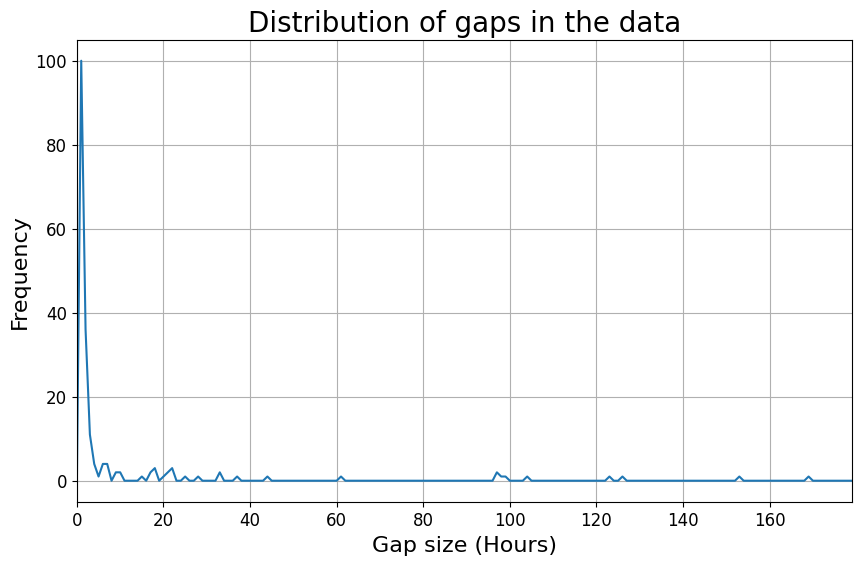

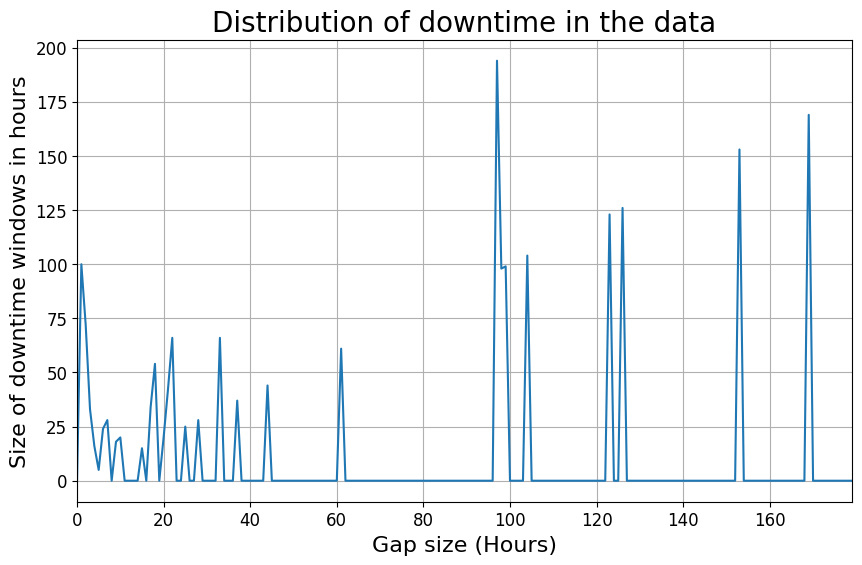

NA Sequence Length Stats:
	Count: 74583,
	Percentage: 2.513%,
	Mean: 9.8
	Median: 1.0
	Mode: 1
	Max: 169



In [6]:
# Plot the distribution of gap sizes in the data
prep_utils.plot_distribution_of_gaps(df, target='PM2.5',  distribution_length=180)

<div class="alert">
We can see that we have a lot of frequent but short segments, but also a few longer gaps, some around to 100, 150, where the longest is 169 hours!
</div>

<div class="alert">
<h3>Explore Simple Methods for Estimating Missing Values on PM2.5</h3>

Perhaps the most straightforward way to estimate missing value in your data is to simply take the last known value in the series and use it to replace the missing value. Another option would be to use a current measurement from the nearest station (nearest neighbor method).
</div>


<div class="alert">
But also, we see that the two pollutant show a good level of correlation, so a Lineal Regression should be considered as alternative.
</div>

In [7]:
pollutants_list = ['PM2.5', 'PM10']
df[pollutants_list].corr()

,PM2.5,PM10
PM2.5,1.00000,0.80821
PM10,0.80821,1.00000


<div class="alert">
We are going to display the different alternatives:
</div>

In [8]:
# Specify some date to plot
day = datetime(2023, 10, 6)

# Create a plot to display the linear interpolation for a range of hours
prep_utils.visualize_missing_values_estimation_pm25(df, day)

interactive(children=(Dropdown(description='Station', options=('Cerrillos II', 'Cerro Navia', 'El Bosque', 'La…

<function prepare_utils.visualize_missing_values_estimation_pm25.<locals>.selector(station, hour_start, window_size, target)>

<div class="alert">
Through this simple exploration, it becomes apparent that Nearest Neighbor and Linear Regression tend to yield better results, particularly for longer data gaps.
<p>

However, we will leverage the Median Absolute Error, which measures how far predictions deviate from actual data, to determine the optimal approach. <br> 
To establish a baseline model, we will calculate the mean and then explore alternative methods, including a Simple Imputer using the mode, Nearest Neighbor, and Linear Regression.
</div>


In [9]:
# Imputation scores
pm25_inputation_scores = {}

pm25_inputation__mean_model, pm25_inputation_scores['baseline_model (mean)'] = prep_utils.calculate_mae_for_station_using_mean(df, target='PM2.5')
pm25_inputation__mode_model, pm25_inputation_scores['Mode'] = prep_utils.calculate_mae_for_station_using_mode(df, target='PM2.5')
pm25_inputation__knn_model, pm25_inputation_scores['KNN'] = prep_utils.calculate_mae_for_nearest_station(df, target='PM2.5')
pm25_inputation__lr_model, pm25_inputation_scores['Lineal Resgression'] = prep_utils.calculate_mae_for_station_using_lr(df, independent='PM10', target='PM2.5')

In [10]:
prep_utils.print_mae_results(pm25_inputation_scores)

MODEL                     MAE        RMSE       MAPE      
baseline_model (mean)     14.12      19.41      1.08      
Mode                      15.09      23.86      0.57      
KNN                       8.65       14.30      0.49      
Lineal Resgression        7.92       11.38      0.45      


<div class="alert">
As we can see, a classic Lineal Regression has the lowest MAE.

However, considering the presence of NA values in some PM10 entries, we will explore methods for imputing those missing values.
</div>

<div class="alert">
<h5>Exploration of imputation alternatives for PM10</h>

</div> 

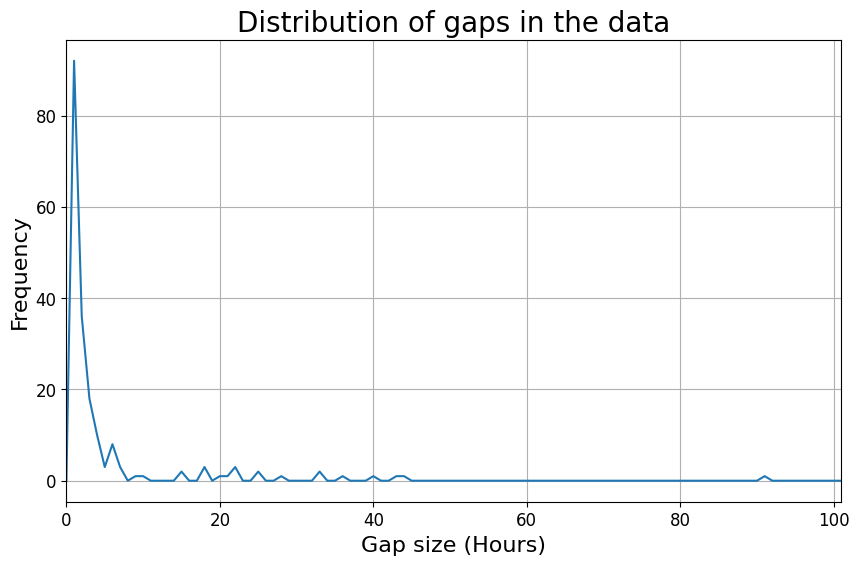

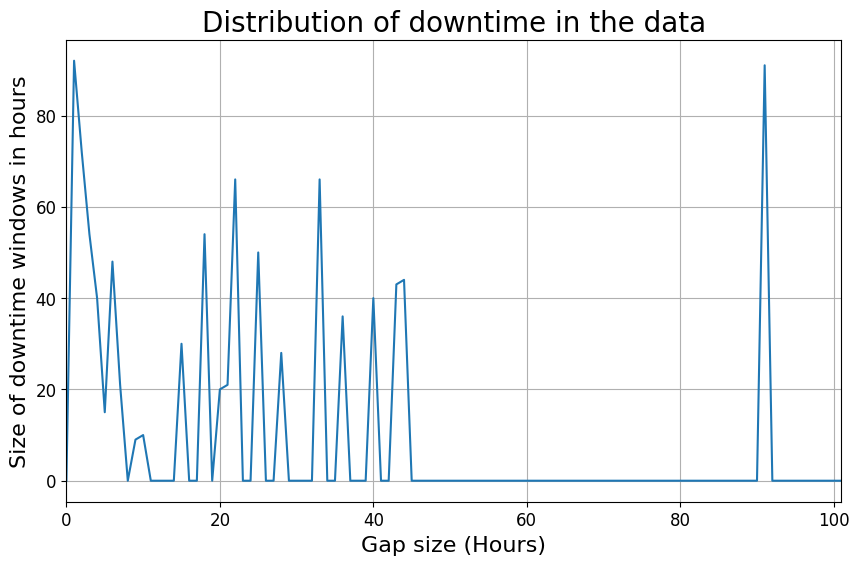

NA Sequence Length Stats:
	Count: 74583,
	Percentage: 1.274%,
	Mean: 4.9
	Median: 2.0
	Mode: 1
	Max: 91



In [11]:
# Plot the distribution of gap sizes in the data
prep_utils.plot_distribution_of_gaps(df, target='PM10')

<div class="alert">
<h3>Explore Simple Methods for Estimating Missing Values in PM10</h3>

In this section, we will employ two straightforward methods to handle missing values in the PM10 data. 

The first method involves replacing missing values with the last known value in the series. The second method utilizes a current measurement from the nearest station, following the nearest neighbor approach.
</div>


In [12]:
# Specify some date to plot
day = datetime(2023, 10, 6)

# Create a plot to display the linear interpolation for a range of hours
prep_utils.visualize_missing_values_estimation_pm10(df, day)

interactive(children=(Dropdown(description='Station', options=('Cerrillos II', 'Cerro Navia', 'El Bosque', 'La…

<function prepare_utils.visualize_missing_values_estimation_pm10.<locals>.selector(station, hour_start, window_size, target)>

<div class="alert">
<p>Through this initial exploration, it is clear that the Nearest Neighbor method returns more promising results.</p>

<p>But again, we will further assess the performance using the Median Absolute Error (MAE). To establish a baseline model, we will calculate the mean and subsequently explore alternative methods. This exploration includes a Simple Imputer using the mode and the Nearest Neighbor approach.</p>
</div>

In [13]:
pm10_inputation_scores = {}

pm10_inputation__mean_model, pm10_inputation_scores['baseline_model (mean)'] = prep_utils.calculate_mae_for_station_using_mean(df, target='PM10')
pm10_inputation__mode_model, pm10_inputation_scores['Mode'] = prep_utils.calculate_mae_for_station_using_mode(df, target='PM10')
pm10_inputation__knn_model, pm10_inputation_scores['KNN'] = prep_utils.calculate_mae_for_nearest_station(df, target='PM10', n_neighbors=4)


In [14]:
prep_utils.print_mae_results(pm10_inputation_scores)

MODEL                     MAE        RMSE       MAPE      
baseline_model (mean)     31.67      43.36      0.82      
Mode                      32.36      48.85      0.56      
KNN                       18.66      28.95      0.34      


<div class="alert">
As we can see, KNN provides the lowest MAE.
</div>

<div class="alert">
<h3>Imputation</h3>
We proceed to impute the missing values, we will use KNN for PM10 and Lineal Regression for PM2.5. 
</div>

In [15]:
# Imputate PM10 missing values with the nearest neighbor method
imputed_with_knn = prep_utils.impute_pollutant_missing_values_with_knn(df, "PM10", pm10_inputation__knn_model)

In [16]:
# Imputate missing PM2.5 values with LR
data_with_imputed = prep_utils.impute_target_missing_values_with_lineal_regression_model(df_with_missing=imputed_with_knn, model=pm25_inputation__lr_model, indepentend_var="PM10", target="PM2.5")

In [17]:
show(data_with_imputed)

<div class="alert">
Finally, export the processed data!
</div> 

In [18]:
#save data
prep_utils.save_interim_data(data_with_imputed, 'stations_data_with_imputed_values')